Лабораторная работа 1
“Сбор, визуализация и анализ данных по графу”


Установка библиотек

In [ ]:
%%capture
!pip install feedparser

In [ ]:
import feedparser
import urllib.request as libreq
import pandas as pd

# Загрузка данных по API

250 обьектов - описаний статей

*Данные про базы данных*

In [ ]:
# data collection

query = "Databases"
max_amount = 250
url = f"https://export.arxiv.org/api/query?search_query=all:{query}&start=0&max_results={max_amount}"
with libreq.urlopen(url) as url:
  r = url.read()
print(r)
docs = feedparser.parse(r)

b'<?xml version="1.0" encoding="UTF-8"?>\n<feed xmlns="http://www.w3.org/2005/Atom">\n  <link href="http://arxiv.org/api/query?search_query%3Dall%3ADatabases%26id_list%3D%26start%3D0%26max_results%3D250" rel="self" type="application/atom+xml"/>\n  <title type="html">ArXiv Query: search_query=all:Databases&amp;id_list=&amp;start=0&amp;max_results=250</title>\n  <id>http://arxiv.org/api/LlHaZLKe/pshXXDxsg+QoCuSiRU</id>\n  <updated>2025-09-22T00:00:00-04:00</updated>\n  <opensearch:totalResults xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">33020</opensearch:totalResults>\n  <opensearch:startIndex xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">0</opensearch:startIndex>\n  <opensearch:itemsPerPage xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">250</opensearch:itemsPerPage>\n  <entry>\n    <id>http://arxiv.org/abs/1606.00740v1</id>\n    <updated>2016-06-02T16:07:15Z</updated>\n    <published>2016-06-02T16:07:15Z</published>\n    <title>The Meaning of Null in Datab

Парсим данные в структуру, выбираем только нужные нам поля - title, summary, authors (создание датасета)

In [ ]:
%time

pubs = []
for entry in docs["entries"]:
  data = {"title": entry['title'],
          "summary": entry['summary'],
          "authors": [author['name'] for author in entry['authors']],
    }
  pubs.append(data)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


In [ ]:
df = pd.DataFrame(pubs)
df

,title,summary,authors
0,The Meaning of Null in Databases and Programmi...,The meaning of null in relational databases is...,[Kenneth Baclawski]
1,A collection of database industrial techniques...,Databases play an essential role in our societ...,[Jasper Kyle Catapang]
2,Managing Variability in Relational Databases b...,Variability inherently exists in databases in ...,"[Parisa Ataei, Qiaoran Li, Eric Walkingshaw, A..."
3,Firebird Database Backup by Serialized Databas...,This paper presents a simple data dump and loa...,[Maurice HT Ling]
4,Disjunctive Databases for Representing Repairs,This paper addresses the problem of representi...,"[Cristian Molinaro, Jan Chomicki, Jerzy Marcin..."
...,...,...,...
245,Detecting Data Type Inconsistencies in a Prope...,Some property graph databases do not have a fi...,"[Joshua R. Porter, Michael N. Young, Aleks Y. ..."
246,SAP HANA Data Volume Management,Today information technology is a data-driven ...,[Subhadip Kumar]
247,Attribution-Scores in Data Management and Expl...,We describe recent research on the use of actu...,[Leopoldo Bertossi]
248,Adaptive Search Optimization: Dynamic Algorith...,Efficient search operations in databases are p...,[Hakikat Singh]


### Загрузка модели для извлечения ключевых слов с HuggingFace


In [ ]:
%%time
# keywords extraction

from transformers import pipeline

pipe = pipeline("text2text-generation", model="ilsilfverskiold/tech-keywords-extractor")

Device set to use cpu


CPU times: user 554 ms, sys: 59.6 ms, total: 613 ms
Wall time: 905 ms


### Извлечение ключевых слов по загаловку и анотации


In [ ]:
from tqdm.auto import tqdm

In [ ]:
%%time
tqdm.pandas()
df["title_summary"] = df["title"] + ". " + df["summary"]
df["keywords"] = df["title_summary"].progress_apply(lambda x: pipe(x)[0]["generated_text"].split(", "))

  0%|          | 0/250 [00:00<?, ?it/s]

CPU times: user 32min 33s, sys: 1.8 s, total: 32min 35s
Wall time: 32min 57s


In [ ]:
df[:10]

,title,summary,authors,title_summary,keywords
0,The Meaning of Null in Databases and Programmi...,The meaning of null in relational databases is...,[Kenneth Baclawski],The Meaning of Null in Databases and Programmi...,"[Null, Databases, Programming Languages]"
1,A collection of database industrial techniques...,Databases play an essential role in our societ...,[Jasper Kyle Catapang],A collection of database industrial techniques...,"[Database Industrial Techniques, Database Opti..."
2,Managing Variability in Relational Databases b...,Variability inherently exists in databases in ...,"[Parisa Ataei, Qiaoran Li, Eric Walkingshaw, A...",Managing Variability in Relational Databases b...,"[Variability, Relational Databases, VDBMS, VRA..."
3,Firebird Database Backup by Serialized Databas...,This paper presents a simple data dump and loa...,[Maurice HT Ling],Firebird Database Backup by Serialized Databas...,"[Firebird, Database Backup, Serialized Databas..."
4,Disjunctive Databases for Representing Repairs,This paper addresses the problem of representi...,"[Cristian Molinaro, Jan Chomicki, Jerzy Marcin...",Disjunctive Databases for Representing Repairs...,"[Disjunctive Databases, Denial Constraints, Fu..."
5,Database Aggregation,Knowledge can be represented compactly in a mu...,"[Francesco Belardinelli, Umberto Grandi]",Database Aggregation. Knowledge can be represe...,"[Database Aggregation, Rational Choice Theory,..."
6,Context-based Ontology Modelling for Database:...,This research paper explores the use of ChatGP...,"[Wenjun Lin, Paul Babyn, Yan yan, Wenjun Zhang]",Context-based Ontology Modelling for Database:...,"[ChatGPT, AI, Database Management, Semantic Da..."
7,Mragyati : A System for Keyword-based Searchin...,"The web, through many search engine sites, has...","[N. L. Sarda, Ankur Jain]",Mragyati : A System for Keyword-based Searchin...,"[Mragyati, Keyword-based Searching, Databases,..."
8,Database Semantics,"This paper, the first step to connect relation...",[Robert E. Kent],"Database Semantics. This paper, the first step...","[Database Semantics, System Consequence, Infor..."
9,EMIT: Micro-Invasive Database Configuration Tu...,The process of database knob tuning has always...,"[Jian Geng, Hongzhi Wang, Yu Yan]",EMIT: Micro-Invasive Database Configuration Tu...,"[EMIT, Database Configuration Tuning, Database..."


Переводим столбцы keywords и authors в строки вместо массивов

In [ ]:
df["keywords"] = df["keywords"].apply(lambda x: ", ".join(x))
df

,title,summary,authors,title_summary,keywords
0,The Meaning of Null in Databases and Programmi...,The meaning of null in relational databases is...,[Kenneth Baclawski],The Meaning of Null in Databases and Programmi...,"Null, Databases, Programming Languages"
1,A collection of database industrial techniques...,Databases play an essential role in our societ...,[Jasper Kyle Catapang],A collection of database industrial techniques...,"Database Industrial Techniques, Database Optim..."
2,Managing Variability in Relational Databases b...,Variability inherently exists in databases in ...,"[Parisa Ataei, Qiaoran Li, Eric Walkingshaw, A...",Managing Variability in Relational Databases b...,"Variability, Relational Databases, VDBMS, VRA,..."
3,Firebird Database Backup by Serialized Databas...,This paper presents a simple data dump and loa...,[Maurice HT Ling],Firebird Database Backup by Serialized Databas...,"Firebird, Database Backup, Serialized Database..."
4,Disjunctive Databases for Representing Repairs,This paper addresses the problem of representi...,"[Cristian Molinaro, Jan Chomicki, Jerzy Marcin...",Disjunctive Databases for Representing Repairs...,"Disjunctive Databases, Denial Constraints, Fun..."
...,...,...,...,...,...
245,Detecting Data Type Inconsistencies in a Prope...,Some property graph databases do not have a fi...,"[Joshua R. Porter, Michael N. Young, Aleks Y. ...",Detecting Data Type Inconsistencies in a Prope...,"Data Type Inconsistencies, Property Graph Data..."
246,SAP HANA Data Volume Management,Today information technology is a data-driven ...,[Subhadip Kumar],SAP HANA Data Volume Management. Today informa...,"SAP HANA, Data Volume Management, HANA S/4, ER..."
247,Attribution-Scores in Data Management and Expl...,We describe recent research on the use of actu...,[Leopoldo Bertossi],Attribution-Scores in Data Management and Expl...,"Attribution-Scores, Data Management, Explainab..."
248,Adaptive Search Optimization: Dynamic Algorith...,Efficient search operations in databases are p...,[Hakikat Singh],Adaptive Search Optimization: Dynamic Algorith...,"Adaptive Search Optimization, Dynamic Algorith..."


In [ ]:
df["authors"] = df["authors"].apply(lambda x: ", ".join(x))
df

,title,summary,authors,title_summary,keywords
0,The Meaning of Null in Databases and Programmi...,The meaning of null in relational databases is...,Kenneth Baclawski,The Meaning of Null in Databases and Programmi...,"Null, Databases, Programming Languages"
1,A collection of database industrial techniques...,Databases play an essential role in our societ...,Jasper Kyle Catapang,A collection of database industrial techniques...,"Database Industrial Techniques, Database Optim..."
2,Managing Variability in Relational Databases b...,Variability inherently exists in databases in ...,"Parisa Ataei, Qiaoran Li, Eric Walkingshaw, Ar...",Managing Variability in Relational Databases b...,"Variability, Relational Databases, VDBMS, VRA,..."
3,Firebird Database Backup by Serialized Databas...,This paper presents a simple data dump and loa...,Maurice HT Ling,Firebird Database Backup by Serialized Databas...,"Firebird, Database Backup, Serialized Database..."
4,Disjunctive Databases for Representing Repairs,This paper addresses the problem of representi...,"Cristian Molinaro, Jan Chomicki, Jerzy Marcink...",Disjunctive Databases for Representing Repairs...,"Disjunctive Databases, Denial Constraints, Fun..."
...,...,...,...,...,...
245,Detecting Data Type Inconsistencies in a Prope...,Some property graph databases do not have a fi...,"Joshua R. Porter, Michael N. Young, Aleks Y. M...",Detecting Data Type Inconsistencies in a Prope...,"Data Type Inconsistencies, Property Graph Data..."
246,SAP HANA Data Volume Management,Today information technology is a data-driven ...,Subhadip Kumar,SAP HANA Data Volume Management. Today informa...,"SAP HANA, Data Volume Management, HANA S/4, ER..."
247,Attribution-Scores in Data Management and Expl...,We describe recent research on the use of actu...,Leopoldo Bertossi,Attribution-Scores in Data Management and Expl...,"Attribution-Scores, Data Management, Explainab..."
248,Adaptive Search Optimization: Dynamic Algorith...,Efficient search operations in databases are p...,Hakikat Singh,Adaptive Search Optimization: Dynamic Algorith...,"Adaptive Search Optimization, Dynamic Algorith..."


Сохраняем полученный датафрейм в csv, чтобы не совершать повторную загрузку данных

In [ ]:
df.to_csv("datastore_data_250.csv", index=False)

### Построения графа ключевых слов

### Загрузка библиотек и данных

In [ ]:
import pandas as pd
import networkx as nx
from itertools import combinations, chain
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from operator import itemgetter
import plotly.graph_objects as go

In [ ]:
df = pd.read_csv("datastore_data_250.csv")
df.sample(10)

,title,summary,authors,title_summary,keywords
131,Translating synthetic natural language to data...,The number of databases as well as their size ...,"Adrián Bazaga, Nupur Gunwant, Gos Micklem",Translating synthetic natural language to data...,"Polyglotter, Deep Learning, Synthetic Natural ..."
77,Database Repairs and Analytic Tableaux,"In this article, we characterize in terms of a...","Leopoldo Bertossi, Camilla Schwind",Database Repairs and Analytic Tableaux. In thi...,"Database Repairs, Analytic Tableaux, Relationa..."
219,Using Grid Files for a Relational Database Man...,This paper describes our experience with using...,"S. M. Joshi, S. Sanyal, S. Banerjee, S. Srikumar",Using Grid Files for a Relational Database Man...,"Grid Files, Relational Database, Database Mana..."
240,State-of-the-Art on Query & Transaction Proces...,The vast amount of processing power and memory...,"Bernd Amann, Youry Khmelevsky, Gaetan Hains",State-of-the-Art on Query & Transaction Proces...,"GPU, Query Processing, Transaction Processing,..."
165,Query Rewriting and Optimization for Ontologic...,Ontological queries are evaluated against a kn...,"Georg Gottlob, Giorgio Orsi, Andreas Pieris",Query Rewriting and Optimization for Ontologic...,"Query Rewriting, Optimization, Ontological Dat..."
55,Query Optimization Techniques In Graph Databases,Graph databases (GDB) have recently been arise...,Ali Ben Ammar,Query Optimization Techniques In Graph Databas...,"Query Optimization Techniques, Graph Databases..."
112,The WebContent XML Store,"In this article, we describe the XML storage s...","Benjamin Nguyen, Spyros Zoupanos","The WebContent XML Store. In this article, we ...","XML, WebContent, Database, P2P"
153,Repairing Inconsistent Databases: A Model-Theo...,In this paper we consider two points of views ...,"Ofer Arieli, Marc Denecker, Bert Van Nuffelen,...",Repairing Inconsistent Databases: A Model-Theo...,"Model-Theoretic, Abductive Reasoning, Data Int..."
12,GRAD: On Graph Database Modeling,Graph databases have emerged as the fundamenta...,"Amine Ghrab, Oscar Romero, Sabri Skhiri, Aleja...",GRAD: On Graph Database Modeling. Graph databa...,"GRAD, Graph Database Modeling, Graph Structure..."
197,Incremental Consistent Updating of Incomplete ...,Efficient consistency maintenance of incomplet...,"Jacques Chabin, Mirian Halfeld Ferrari, Nicola...",Incremental Consistent Updating of Incomplete ...,"Incremental Consistent Updating, Incomplete Da..."


### Создание взвешенных ребер из ключевых слов

- Узлы — это отдельные ключевые слова

- Рёбра — если два ключевых слова встречаются в одной публикации

- Вес ребра — сколько раз такая пара встретилась в разных публикациях

создаем из строк список списков ключевых слов по каждой публикации

In [ ]:
klist = [[word.strip() for word in keywords.split(",") if word]
         for keywords in df["keywords"].tolist()]
klist[:3]

[['Null', 'Databases', 'Programming Languages'],
 ['Database Industrial Techniques', 'Database Optimization'],
 ['Variability',
  'Relational Databases',
  'VDBMS',
  'VRA',
  'Software Development',
  'Database Evolution']]

In [ ]:
edges = list(chain(*[list(combinations(words, 2)) for words in klist])) # Построение пар ключевых слов внутри каждой публикации
edges = [tuple(sorted(edge)) for edge in edges] # Упорядочивание пар, чтобы пары с одинаковыми словами считались одной парой, даже если порядок слов разный был
weighted_edges = [(edge[0], edge[1], {"weight": edges.count(edge)}) for edge in set(edges)] # Подсчёт веса рёбер
weighted_edges[:10]

[('Apache Accumulo', 'Database Operations', {'weight': 1}),
 ('Conditioning Probabilistic Databases',
  'Confidence Computation',
  {'weight': 1}),
 ('Inductive Logic Programming', 'Reasoning Systems', {'weight': 1}),
 ('CBDB', 'Graph', {'weight': 1}),
 ('Database Fingerprinting', 'Relational Databases', {'weight': 1}),
 ('Robot Configuration Space', 'Simulation', {'weight': 1}),
 ('Constrained Pattern Mining', 'Database Transposition', {'weight': 1}),
 ('Cognitive Database', 'NLP', {'weight': 1}),
 ('DynamoDB', 'Firebase', {'weight': 1}),
 ('HANA S/4', 'SAP HANA', {'weight': 1})]

In [ ]:
len(set(edges)), len(weighted_edges)

(2206, 2206)

Построение графа с помощью https://networkx.org/

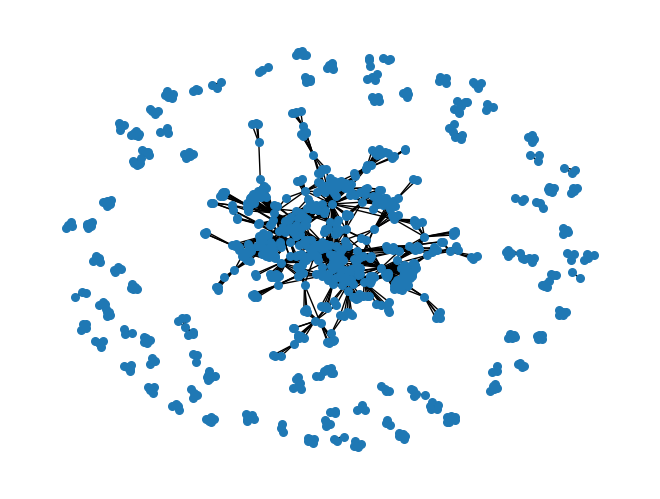

In [ ]:
G = nx.Graph()
G.add_edges_from(weighted_edges)
nx.draw(G, with_labels=False, font_weight='bold', node_size=30)

#### Выделение сообществ на графе




In [ ]:
communities = nx.community.louvain_communities(G, resolution=0.9) # выделяем кластеры с помощью louvain_communities, который основывается на максимизации модулярности
# resolution=0.9 - Управляет размером кластеров
# получаем communities - список кластеров, где каждый кластер - это множество узлов
modularity = nx.community.modularity(G, communities) # оцениваем качество кластеризации по метрике модулярности
print(f"# of clusters: {len(communities)}, Modularity: {modularity:.4f}")

# of clusters: 93, Modularity: 0.8755


Итог: 93 кластеров и Модулярность 0.8755
Такая высокая Модулярностьговорит о следующем:
- Ключевые слова внутри каждого кластера сильно связаны друг с другом

- Между кластерами — почти нет лишних связей

- Ключевые слова внутри кластеров принадлежат к одной теме

In [ ]:
comm_data = [{"n_of_nodes": len(comm), "nodes": comm} for comm in communities] # n_of_nodes - количество ключевых слов в кластере, nodes - сами слова
cdf = pd.DataFrame(comm_data) # Преобразуем список словарей в таблицу, где каждая строка - один кластер.
cdf.describe()

,n_of_nodes
count,93.000000
mean,9.741935
std,13.900972
min,2.000000
25%,4.000000
50%,5.000000
75%,6.000000
max,65.000000


Анализ таблицы:
- Всего 93 кластеров
- В среднем 9,7 ключевых слова на кластер
- Большое стандартное отклонение - кластеры сильно различаются по размеру
- Минимальное колличество слов в кластере - 2
- 25% кластеров содержит ≤ 4 слова
- 50% кластеров содержит ≤ 5 слова
- 75% кластеров содержат ≤ 6 слов
- Максимальное колличество слов в кластере - 65

Три самых крупных кластера ключевых слов

In [ ]:
top3_comm = cdf.nlargest(3, "n_of_nodes")
top3_comm

,n_of_nodes,nodes
62,65,"{SPARQL, OpenStreetMap, Optimization Approach,..."
21,62,"{Customized Architecture, Support Vector Machi..."
2,60,"{Cover Story Management, Relational Databases,..."


In [ ]:
from collections import Counter

top5_comm = cdf.nlargest(5, "n_of_nodes") # топ пять кластеров по нодам

for idx, row in top5_comm.iterrows(): # вычисляем топ 10 слов в каждом кластере
    phrases = list(row["nodes"])
    words = []
    for phrase in phrases:
        words.extend(phrase.lower().split())
    counter = Counter(words)
    top_terms = counter.most_common(10)
    print(f"Cluster #{idx} ({row['n_of_nodes']} nodes):")
    for term, freq in top_terms:
        print(f"  {term}: {freq} times")



Cluster #62 (65 nodes):
  database: 6 times
  configuration: 3 times
  optimization: 2 times
  networking: 2 times
  databases: 2 times
  xml: 2 times
  data: 2 times
  grammar: 2 times
  sparql: 1 times
  openstreetmap: 1 times
Cluster #21 (62 nodes):
  database: 7 times
  data: 5 times
  databases: 4 times
  system: 3 times
  architecture: 2 times
  image: 2 times
  watermarking: 2 times
  relational: 2 times
  model: 2 times
  graph: 2 times
Cluster #2 (60 nodes):
  database: 8 times
  management: 3 times
  systems: 3 times
  system: 3 times
  relational: 2 times
  databases: 2 times
  owl: 2 times
  data: 2 times
  hybrid: 2 times
  knowledge: 2 times
Cluster #6 (59 nodes):
  database: 4 times
  learning: 3 times
  data: 3 times
  null: 2 times
  constraints: 2 times
  databases: 2 times
  query: 2 times
  disjunctive: 2 times
  logic: 2 times
  repair: 2 times
Cluster #34 (43 nodes):
  database: 8 times
  databases: 4 times
  choice: 2 times
  queries: 2 times
  repair: 2 times
  

#Проанализируем темы топ 5 кластеров по колиичеству node опираясь на топ 10 ключевых слов

## Cluster #62 (65 узлов)
Топ 10 ключевых слов дают нам понять о том, что тема данных статей может быть связана с настройкой (configuration) и оптимизацией (optimization) баз данных в сетевых (networking) и семантических приложениях (grammar).


##Cluster #21 (62 узла)
Ключевые слова говорят о том, что темой может быть проектировка нереляционных баз данных (database, data, system, relational и graph) и их защита(image и watermarking).


##Cluster #2 (60 узлов)
Скорее всего, тема связана с гибридными(hybrid) СУБД. Здесь явно пересекаются классические СУБД (database management systems, relational databases) и онтологии/семантические технологии (OWL, knowledge).


##Cluster #6 (59 узлов)
Тема связана с восстановление целостности данных через логико-вычислительные методы(keywords learning, null, constraints и disjunctive logic).


##Cluster #34 (43 узла)
Кластеры объединяют исследования о том, как автоматически починить (repair, choice) запросы и данные в базах с помощью формальных аргументов(Dung).Integrity и graph намекают на работу с графовыми моделями зависимостей.

In [ ]:
communities = top3_comm["nodes"].tolist()
pos = nx.spring_layout(S, iterations=100, seed=23)

# координаты ребер
x_nodes, y_nodes = zip(*pos.values())
edge_x, edge_y = [], []
for edge in S.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# метки степеней
node_labels = [f"Node {n}<br>Degree: {S.degree(n)}" for n in S.nodes()]
node_degrees = [S.degree(n) for n in S.nodes()]
node_colors_list = create_community_node_colors(S, communities)

fig = go.Figure()
# добавляем ребра
fig.add_trace(go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color="gray"),
))

# добавляем узлы
fig.add_trace(go.Scatter(
    x=x_nodes, y=y_nodes, mode="markers",
    marker=dict(size=[deg*1.1+5 for deg in node_degrees], color=node_colors_list),
    hoverinfo="text",
    text=node_labels
))

# настройка фона
fig.update_layout(
    title=f"Interactive Visualization of Top-3 Communities",
    showlegend=False,
    plot_bgcolor="white",
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
)

fig.show()

Оценим разные центральности, а именно closeness_centrality, degree_centrality, eigenvector_centrality, betweenness_centrality

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

def visualize_top_clusters(G, top_n=3, centrality_metric='closeness', top_keywords=10, show_labels=False):
    if centrality_metric == 'closeness':
        centrality = nx.closeness_centrality(G)
    elif centrality_metric == 'degree':
        centrality = nx.degree_centrality(G)
    elif centrality_metric == 'eigenvector':
        centrality = nx.eigenvector_centrality(G)
    elif centrality_metric == 'betweenness':
        centrality = nx.betweenness_centrality(G)
    else:
        raise ValueError("Unsupported centrality metric")

    # вывод топа ключевых слов по заданной центральности
    top_central = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:top_keywords]
    print(f"Топ {top_keywords} ключевыъ слов основываясь на {centrality_metric} центральность:")
    for word, score in top_central:
        print(f"{word}: {score:.4f}")


    # постоение графика
    communities = list(greedy_modularity_communities(G))
    top_communities = sorted(communities, key=len, reverse=True)[:top_n]
    palette = ['red', 'green', 'blue', 'orange', 'purple', 'cyan']
    community_colors = {
        node: palette[i % len(palette)]
        for i, comm in enumerate(top_communities)
        for node in comm
    }

    nodes = list(G.nodes())
    central_vals = np.array([centrality[n] for n in nodes])
    cmap = plt.colormaps.get_cmap('viridis')
    node_colors = [cmap(val) for val in central_vals]
    node_sizes = [500 * centrality[n] for n in nodes]

    fig, ax = plt.subplots(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_edges(G, pos, alpha=0.3, ax=ax)
    nodes_collection = nx.draw_networkx_nodes(
        G, pos,
        nodelist=nodes,
        node_color=node_colors,
        node_size=node_sizes,
        edgecolors='black',
        ax=ax
    )
    if show_labels:
        nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)

    ax.set_title(f"Top {top_n} Кластеры с {centrality_metric.capitalize()} центральностью")
    ax.axis('off')

    norm = Normalize(vmin=central_vals.min(), vmax=central_vals.max())
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array(central_vals)
    fig.colorbar(sm, ax=ax, label=f'{centrality_metric.capitalize()} Centrality')

    plt.show()


Топ 10 ключевыъ слов основываясь на closeness центральность:
NLP: 0.2187
Database: 0.2187
Relational Databases: 0.2118
NoSQL: 0.2118
Deep Learning: 0.2046
Graph Database: 0.2006
Large Language Models: 0.1998
Databases: 0.1989
Big Data: 0.1983
Machine Learning: 0.1972


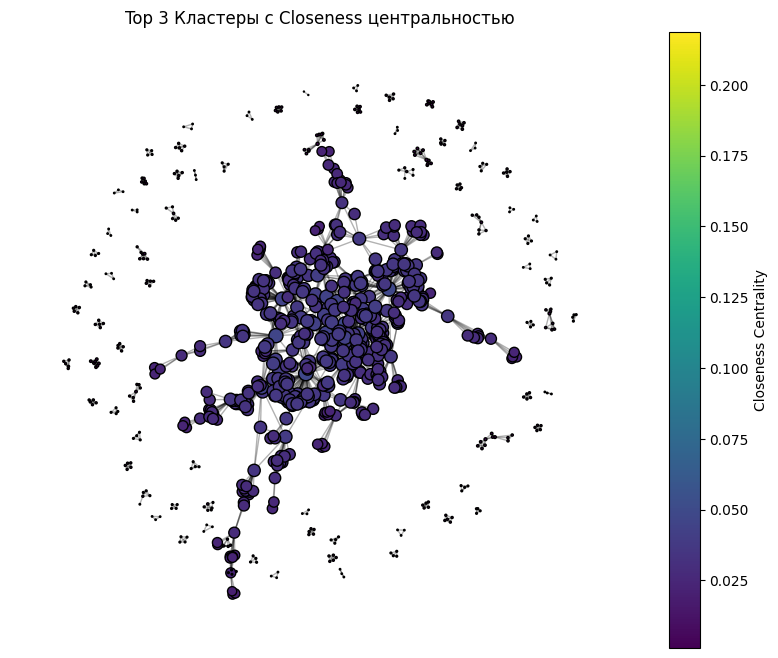

Топ 10 ключевыъ слов основываясь на degree центральность:
Database: 0.0796
Relational Databases: 0.0696
Databases: 0.0652
Relational Database: 0.0486
NoSQL: 0.0387
MongoDB: 0.0354
Algorithms: 0.0265
NLP: 0.0243
Deep Learning: 0.0243
SQL: 0.0243


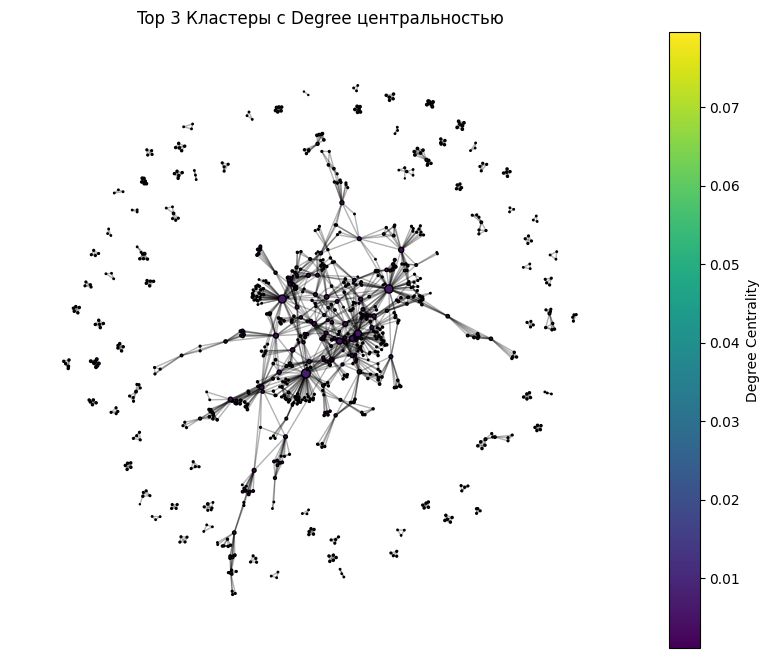

Топ 10 ключевыъ слов основываясь на eigenvector центральность:
Database: 0.4393
MongoDB: 0.2255
NoSQL: 0.2086
Relational Databases: 0.1928
Neo4j: 0.1521
NLP: 0.1510
Databases: 0.1452
Deep Learning: 0.1452
Graph Database: 0.1327
Big Data: 0.1260


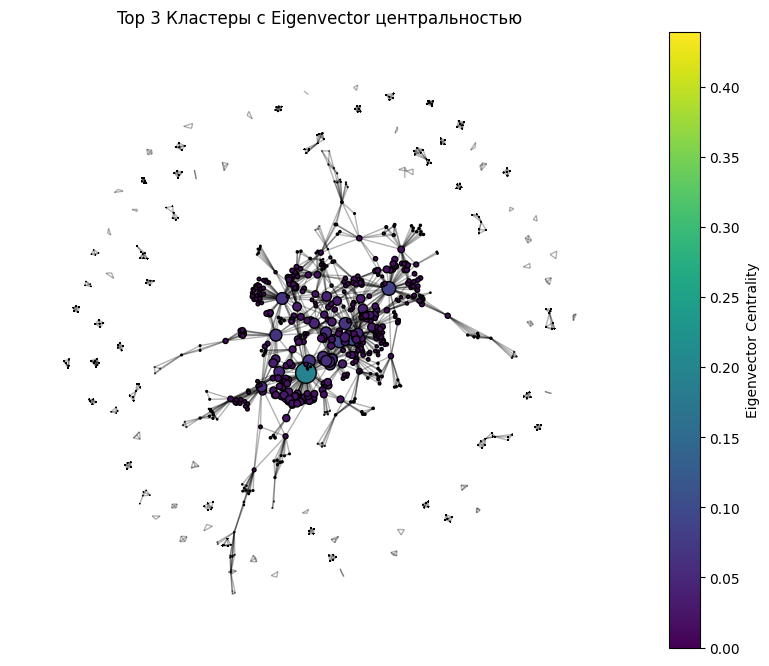

Топ 10 ключевыъ слов основываясь на betweenness центральность:
Relational Databases: 0.1144
Database: 0.1081
Databases: 0.0746
SQL: 0.0573
Relational Database: 0.0534
NoSQL: 0.0519
NLP: 0.0409
Graph Database: 0.0363
Deep Learning: 0.0345
Relational Algebra: 0.0281


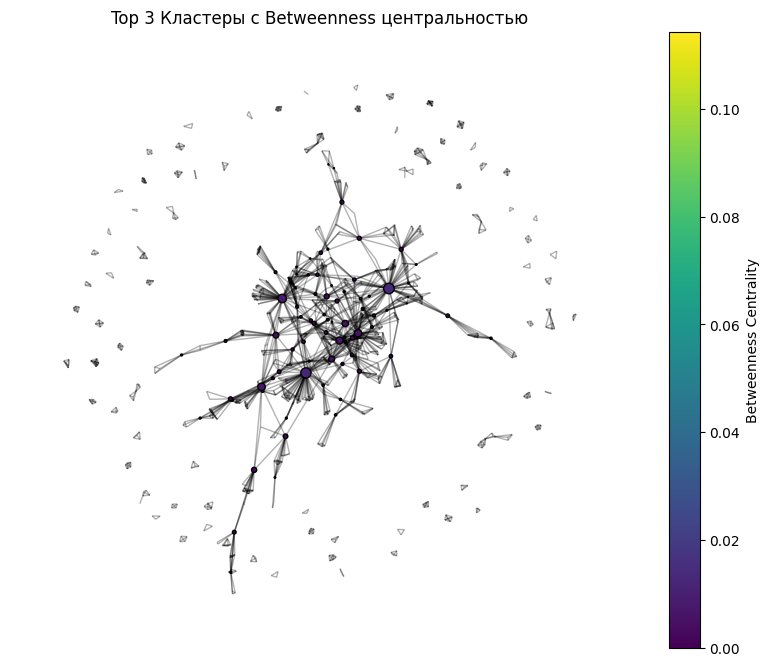

In [ ]:
visualize_top_clusters(G, centrality_metric='closeness')
visualize_top_clusters(G, centrality_metric='degree')
visualize_top_clusters(G, centrality_metric='eigenvector')
visualize_top_clusters(G, centrality_metric='betweenness')

Database — самый "центральный" термин по большинству метрик: он связан с множеством других тем и находится вблизи от них, что похоже на правду, так как тема статей - базы данных

Эти слова — тематические мосты, они соединяют разные области знаний в твоей выборке публикаций.

# **Построение графа публикаций**

- Узлы — публикации

- Рёбра — между публикациями, если у них есть общие ключевые слова

- Вес ребра — количество таких общих слов

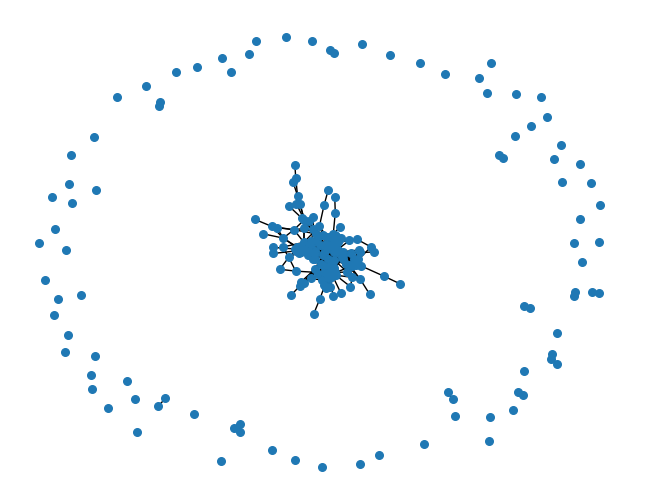

In [ ]:
G_pub = nx.Graph()

# Добавляем узлы — все публикации с атрибутами
for idx, row in df.iterrows():
   G_pub.add_node(idx, title=row["title"], summary=row["summary"], authors=row["authors"])

# Добавляем рёбра — по общим ключевым словам
for i, row_i in df.iterrows():
    keywords_i = set(row_i["keywords"].split(", "))
    for j, row_j in df.iterrows():
        if i >= j:
            continue
        keywords_j = set(row_j["keywords"].split(", "))
        common = keywords_i & keywords_j # смотрим есть ли общие слова
        if common:
            G_pub.add_edge(i, j, weight=len(common)) # добавляем ребро с весом - количество общих слов

nx.draw(G_pub, with_labels=False, font_weight='bold', node_size=30)

Поиск наиболее близких к заданной пользователем публикаций на графе.


In [ ]:
def find_pub_id_by_title(title_query): # получаем по загаловку id публикации и обратно загаловок
    matches = df[df["title"].str.contains(title_query, case=False, na=False)]
    if matches.empty:
        print("Publication not found.")
        return None
    return matches.index[0], matches.iloc[0]["title"]


In [ ]:
def find_similar_publications_by_title(title_query, top_n=5):
    result = find_pub_id_by_title(title_query) #получаем по загаловку id публикации и обратно загаловок
    if result is None:
        return []

    pub_id, matched_title = result
    print(f"\n Publication found:\n{matched_title}\nID: {pub_id}\n")

    if pub_id not in G_pub:
        print("The publication has no links in the graph.")
        return []

    keywords_i = set(df.loc[pub_id, "keywords"].split(", ")) # ключевые слова для публикации
    neighbors = sorted(G_pub[pub_id].items(), key=lambda x: x[1]["weight"], reverse=True) # получаем связаные с этой публикацие публикации и сортируем по весу

    print(f"\n Related publications:")
    for idx, edge in neighbors[:top_n]:
        keywords_j = set(df.loc[idx, "keywords"].split(", ")) # ключевые слова для публикации-соседа
        common_keywords = keywords_i & keywords_j # общие ключевые слова
        print(f"- {df.loc[idx, 'title']} (number ofcommon keywords: {edge['weight']})")
        print(f" common keywords: {', '.join(common_keywords)}\n")


In [ ]:
find_similar_publications_by_title("Relational Database Augmented Large Language Model")



 Publication found:
Relational Database Augmented Large Language Model
ID: 147


 Related publications:
- Trustworthy and Efficient LLMs Meet Databases (number ofcommon keywords: 2)
 common keywords: LLMs, Large Language Models

- Revolutionizing Database Q&A with Large Language Models: Comprehensive
  Benchmark and Evaluation (number ofcommon keywords: 2)
 common keywords: LLMs, Large Language Models

- Context-based Ontology Modelling for Database: Enabling ChatGPT for
  Semantic Database Management (number ofcommon keywords: 1)
 common keywords: NLP

- Discovering new technique for mapping relational database based on
  semantic web technology (number ofcommon keywords: 1)
 common keywords: Relational Database

- Belnap-Dunn logic and query answering in inconsistent databases with
  null values (number ofcommon keywords: 1)
 common keywords: Relational Database



In [ ]:
print(df.loc[147, "keywords"])

Large Language Models, LLMs, Relational Database, NLP
